In [2]:
import importlib, os
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from tqdm.notebook import tqdm
import data_processing.import_data as imp
import data_processing.partition_data as prt
from data_processing.load_env import load_env
import plot_functions.format_axis as fmt

In [3]:
long_data = imp.import_all_longitudinal_files(clean_only=True, add_demog=True)
print('REMOVING SUBJECT m2_0048')
long_data = long_data[long_data.subject_id != 'm2_0048']
print('Remaining Subjects:', long_data.subject_id.nunique())

IMPORTING LONGITUDINAL DATA FROM:
	/Users/akre96/Data/DGC_Study/Longitudinal Data with New Barometric Data
	Only importing patients with demographic information, and data until end of study
	Removed 0 subjects 33 remain
	Filtering for time points newer than June 2016
	Adding Demographic information to longitudinal data
REMOVING SUBJECT m2_0048
Remaining Subjects: 32


In [4]:
importlib.reload(imp)
env = load_env()
sub_dir, files, paths = imp.generate_subject_file_path_list(env)

## Assessing amount of data available if split based on redcap events

In [5]:
importlib.reload(prt)
phase_count_dict = {
    'subject_id': [],
    'phase_start': [],
    'phase_len': [],
}
for fp in tqdm(paths):
    s_data = imp.import_longitudinal_file(fp, True)
    s_id = s_data.subject_id.unique()[0]
    phases = [
        'baseline_arm_1',
        'remote_cat_1_arm_1',
        'remote_cat_2_arm_1',
        'remote_cat_3_arm_1',
        'remote_cat_4_arm_1',
        'remote_cat_5_arm_1',
        'remote_cat_6_arm_1',
        'followup_assessmen_arm_1'
    ]
    for i in range(len(phases)-1):
        start = phases[i]
        end = phases[i+1]
        first_row = s_data[s_data.redcap_event_name_1 == start]
        last_row = s_data[s_data.redcap_event_name_1 == end]
        if first_row.empty or last_row.empty:
            continue
        if (first_row.shape[0] > 1) or (last_row.shape[0] > 1):
            print('Warning: multiple entries for first or last row, using first')
            print(first_row.shape[0], last_row.shape[0])
        chunk = s_data.iloc[first_row.index[0]:last_row.index[0]] 
    
        phase_count_dict['subject_id'].append(s_id)
        phase_count_dict['phase_start'].append(start.split('_arm_1')[0])
        phase_count_dict['phase_len'].append(chunk.shape[0])
    

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

data_count = pd.DataFrame.from_dict(phase_count_dict)
data_count.describe()

,phase_len
count,191.000000
mean,13.565445
std,3.432762
min,1.000000
25%,13.000000
50%,14.000000
75%,14.000000
max,28.000000


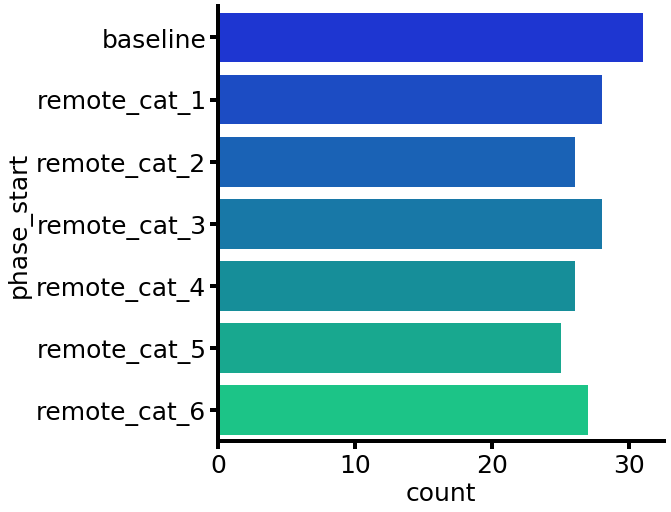

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(
    y=data_count.phase_start,
    ax=ax,
    palette='winter'
)
fmt.despine_thicken_axes(
    ax=ax,
    lw=4,
    fontsize=25,
    rotate_x=0,
)
sns.despine()

phase_len                                                     
                 count       mean       std   min    25%   50%    75%   max
phase_start                                                                
baseline          31.0  14.548387  1.524002  14.0  14.00  14.0  14.00  20.0
remote_cat_1      28.0  15.071429  2.827492   8.0  14.00  14.0  16.00  23.0
remote_cat_2      26.0  13.923077  1.354196  10.0  14.00  14.0  14.75  17.0
remote_cat_3      28.0  14.250000  2.428610   8.0  13.75  14.0  15.00  22.0
remote_cat_4      26.0  14.423077  2.157277   9.0  13.25  14.0  14.75  19.0
remote_cat_5      25.0  13.960000  3.656957   9.0  13.00  14.0  14.00  28.0
remote_cat_6      27.0   8.629630  4.473410   1.0   6.00   8.0  11.50  21.0

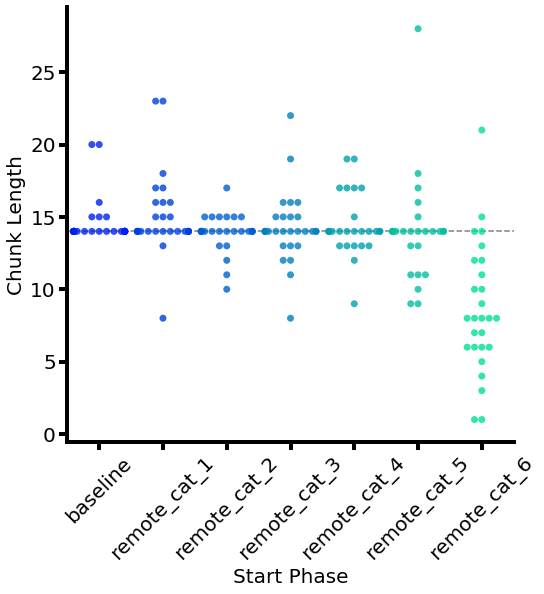

In [8]:

fig, ax = plt.subplots(figsize=(8,8))
sns.swarmplot(
    x='phase_start',
    y='phase_len',
    data=data_count,
    palette='winter',
    ax=ax,
    s=7,
    alpha=0.8
)
ax.hlines([14],ax.get_xlim()[0], ax.get_xlim()[1], ls='dashed', color='gray')
fmt.despine_thicken_axes(
    ax=ax,
    lw=4,
    fontsize=20,
    rotate_x=45,
)
ax.set_ylabel('Chunk Length')
ax.set_xlabel('Start Phase')
sns.despine()
data_count.groupby('phase_start').describe()

In [79]:
data_count.describe()

,phase_len
count,191.000000
mean,13.565445
std,3.432762
min,1.000000
25%,13.000000
50%,14.000000
75%,14.000000
max,28.000000


## Splitting Data in to two week chunks, creating HMM inputs


In [11]:
import data_processing.reshape_data as rd
importlib.reload(rd)
importlib.reload(prt)
min_days = 14
lengths = []
sequences = []
end_sevs = []
start_sevs = []

data_dict = {
    'subject_id': [],
    'start': [],
    'start_date': [],
    'end': [],
    'step_diff': [],
    'call_diff': [],
    'n_migraines': [],
    'start_sev': [],
    'end_sev': [],
    'end_mig_freq': [],
}


for fp in tqdm(paths):
    subject_data = imp.import_longitudinal_file(fp, True)
    if subject_data.subject_id.unique()[0] == 'm2_0048':
        print('Skipping m2_0048')
        continue
    chunks = prt.two_week_subsets(subject_data, min_days)
    sequence = []
    for d in chunks:
        data = d.sort_values(by='Date', ascending=True)
        start = data['start'].unique()[0]
        end = data['end'].unique()[0]
        h1, h2 = prt.split_half(data)
        sid = data.subject_id.unique()[0]
        if 'Step count' not in data.columns:
            print('No Step Count', sid)
            step_diff = np.nan
        else:
            step_diff = h2['Step count'].mean() - h1['Step count'].mean()   
            
        call_diff = h2['outgoing_calls'].mean() - h1['outgoing_calls'].mean()   
        
        n_migraines = rd.melt_occurrances('mbrep_start_date', data).dropna().mbrep_start_date.count()
        start_sev = data['start_sev'].unique()[0]
        end_sev = data.end_sev.unique()[0]
        end_mig_freq = data.end_mig_freq.unique()[0]
        
        data_dict['subject_id'].append(sid)
        data_dict['start'].append(start)
        data_dict['start_date'].append(data['Date'].min())
        data_dict['end'].append(end)
        data_dict['step_diff'].append(step_diff)
        data_dict['call_diff'].append(call_diff)
        data_dict['n_migraines'].append(n_migraines)
        data_dict['start_sev'].append(start_sev)
        data_dict['end_sev'].append(end_sev)
        data_dict['end_mig_freq'].append(end_mig_freq)
        

Skipping -- No Week After Chunk: remote_cat_6_arm_1 to followup_assessmen_arm_1 m2_0049 (1, 80)
Skipping -- No Week After Chunk: remote_cat_5_arm_1 to remote_cat_6_arm_1 m2_0028 (2, 68)
Skipping -- No Week After Chunk: remote_cat_6_arm_1 to followup_assessmen_arm_1 m2_0028 (1, 68)
Skipping -- No Week After Chunk: remote_cat_6_arm_1 to followup_assessmen_arm_1 m2_0009 (1, 100)
Skipping -- No Week After Chunk: remote_cat_6_arm_1 to followup_assessmen_arm_1 m2_0016 (1, 96)
Skipping -- No Week After Chunk: remote_cat_5_arm_1 to remote_cat_6_arm_1 m2_0037 (1, 89)
Skipping -- No Week After Chunk: remote_cat_6_arm_1 to followup_assessmen_arm_1 m2_0013 (1, 76)
No Depression Severity m2_0020
No Depression Severity m2_0020
Skipping -- No Week After Chunk: remote_cat_6_arm_1 to followup_assessmen_arm_1 m2_0032 (1, 76)
Skipping -- No Week After Chunk: remote_cat_5_arm_1 to remote_cat_6_arm_1 m2_0001 (5, 76)
Skipping -- No Week After Chunk: remote_cat_6_arm_1 to followup_assessmen_arm_1 m2_0001 (1,

In [12]:
data_df = pd.DataFrame.from_dict(data_dict)
data_df.describe(percentiles=[.5])

,step_diff,call_diff,n_migraines,start_sev,end_sev,end_mig_freq
count,116.000000,101.000000,127.000000,127.000000,127.000000,127.000000
mean,288.134535,0.131425,2.251969,49.143307,47.120472,0.147357
std,1819.601736,2.980102,2.387030,17.835116,18.749020,0.174442
min,-5048.408170,-7.190476,0.000000,9.300000,9.300000,0.000000
50%,233.755086,0.000000,1.000000,49.900000,47.200000,0.142857
max,5861.416667,18.400000,11.000000,83.200000,83.200000,1.000000


In [13]:
data_df.dropna().describe(percentiles=[.5])

,step_diff,call_diff,n_migraines,start_sev,end_sev,end_mig_freq
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,338.982509,0.164520,2.380435,50.417391,48.938043,0.163043
std,1932.139257,3.111972,2.510822,17.254804,18.672038,0.190114
min,-5048.408170,-7.190476,0.000000,9.700000,9.700000,0.000000
50%,233.755086,0.000000,2.000000,51.250000,50.050000,0.142857
max,5861.416667,18.400000,11.000000,82.100000,83.200000,1.000000


### Turn Aggregate Chunks in to sequences for HMM input

In [15]:
sequences = []
lengths = []
end_sevs = []
end_mig_freqs = []
start_sevs = []
sids = []
last_sid = ''
last_end = ''
sequence = None

features = ['step_diff', 'call_diff', 'n_migraines', 'start_sev']
#features = ['n_migraines', 'start_sev']

for (sid, start, end), df in data_df.dropna().groupby(['subject_id', 'start', 'end']):
    if df.shape[0] != 1:
        print(df)
    event = df[features].to_numpy()[0]
    if (sid == last_sid) and (start == last_end):
        sequence.append(event)
    else:
        if sequence:
            sequences.append(sequence)
            lengths.append(len(sequence))
        sequence = [event]

    last_sid = sid
    last_end = end
    end_sevs.append(df.end_sev.unique()[0])
    end_mig_freqs.append(df.end_mig_freq.unique()[0])
    start_sevs.append(df.start_sev.unique()[0])
    sids.append(sid)
        
sequences.append(sequence)
lengths.append(len(sequence))

In [19]:
X = np.concatenate(sequences)
print('Data Shape', X.shape,'\nN-Sequences:', len(lengths))

Data Shape (92, 4) 
N-Sequences: 38


## Training HMM

In [21]:
n_components=4
model = GaussianHMM(
    n_components=n_components,
    covariance_type='full',
    n_iter=1000,
).fit(X, lengths)

Text(0.5, 1, 'Transition Matrix')

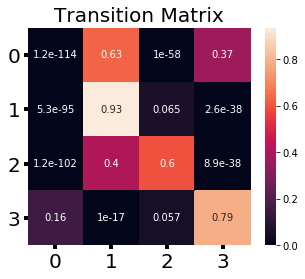

In [22]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(model.transmat_, ax=ax, annot=True)
fmt.despine_thicken_axes(
    ax=ax,
    lw=0,
    fontsize=20,
)
ax.tick_params(length=4, width=4)
ax.set_title('Transition Matrix', fontsize=20)

In [23]:
mod_out = model.predict(X, lengths)
prob_out = model.predict_proba(X, lengths)
diffs = np.array(end_sevs) - np.array(start_sevs)
print(mod_out.shape, prob_out.shape)

(92,) (92, 4)


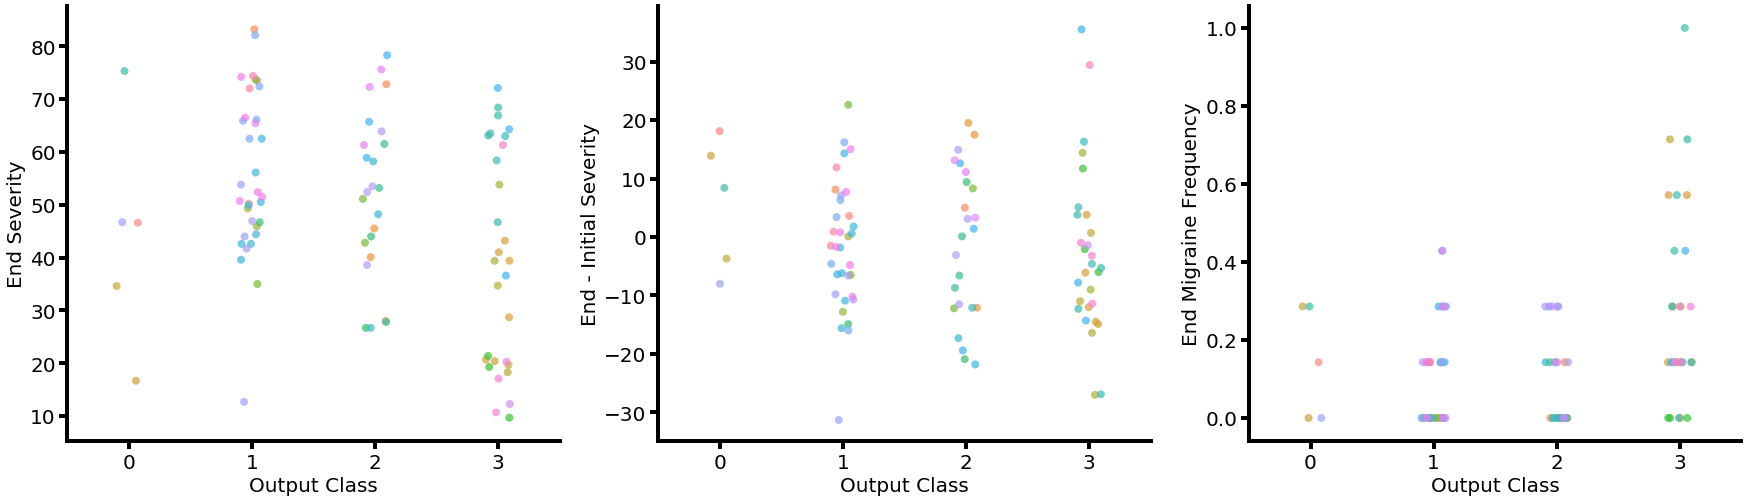

In [25]:
fig, axes = plt.subplots(ncols=3, figsize=(n_components*2.5*3,8))
ys = [end_sevs, diffs, end_mig_freqs]
i = 0
for y in ['End Severity','End - Initial Severity', 'End Migraine Frequency']:
    ax = axes.flatten()[i]
    sns.stripplot(
        x=mod_out,
        y=ys[i],
        hue=sids,
        s=8,
        alpha=0.7,
        ax=ax
    )
    fmt.despine_thicken_axes(
        ax=ax,
        lw=4,
        fontsize=20,
    )
    ax.set_ylabel(y)
    ax.set_xlabel('Output Class')
    ax.legend().remove()
    i+=1

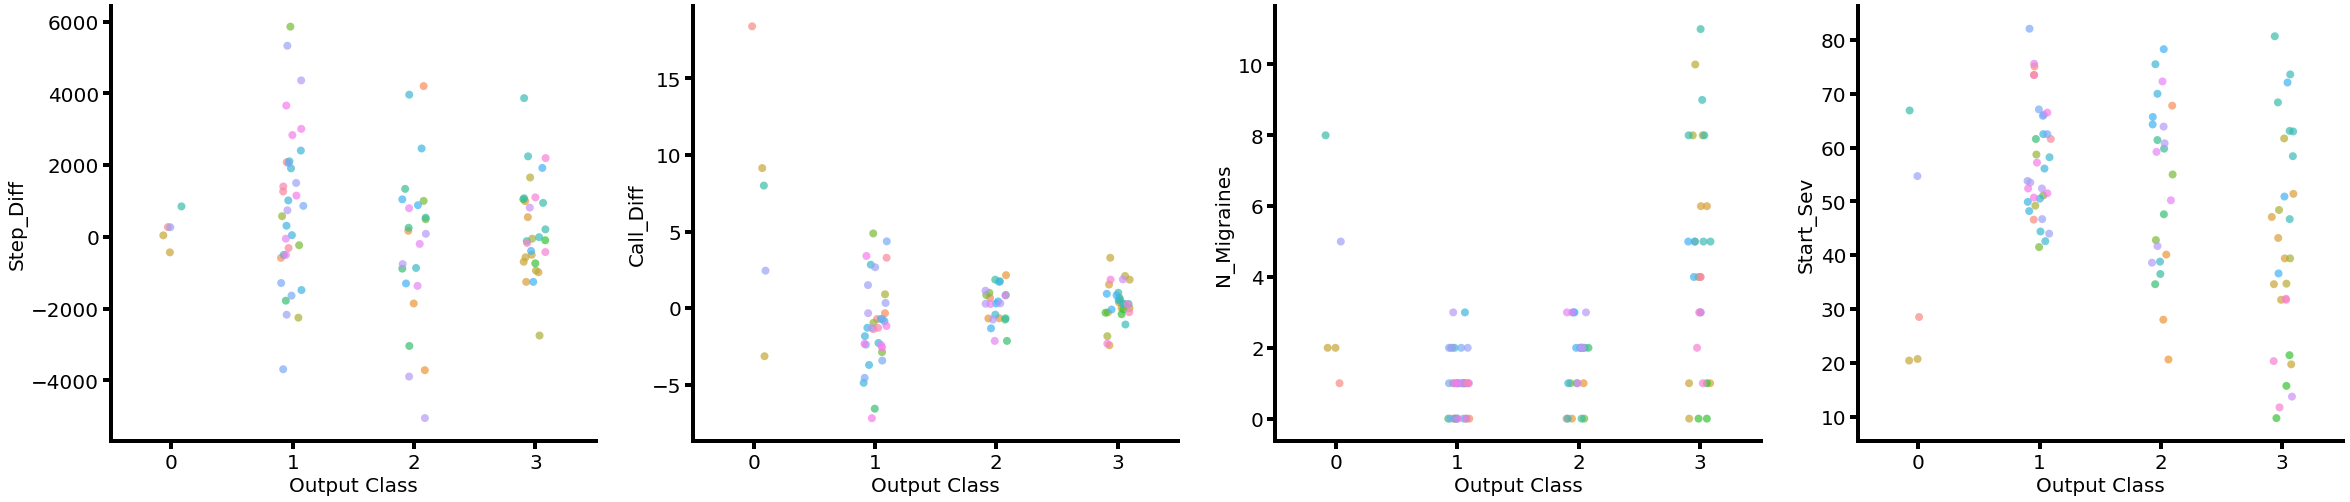

In [26]:

fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(n_components*2.5*len(features),8))
i = 0
for col in features:
    ax = axes.flatten()[i]
    sns.stripplot(
        x=mod_out,
        y=X[:,i],
        hue=sids,
        s=8,
        alpha=0.7,
        ax=ax,
    )
    fmt.despine_thicken_axes(
        ax=ax,
        lw=4,
        fontsize=20,
    )
    ax.set_ylabel(col.title())
    ax.set_xlabel('Output Class')
    ax.legend().remove()
    i += 1

## Evaluating Model

In [27]:
mdd_thresh = 26.56 #57.5
mig_thresh = .29 #.25
mdd = np.array(end_sevs) > mdd_thresh
mdd = mdd.astype(int)
mig = np.array(end_mig_freqs) >= mig_thresh
mig = mig.astype(int)

In [28]:
cats = []
for dep, m in zip(mdd,mig):
    if dep and m:
        cats.append('D + M')
    if dep and not m:
        cats.append('D')
    if not dep and m:
        cats.append('M')
    if not dep and not m:
        cats.append('Neither')
cats = np.array(cats)

,cat,pred,subject_id
0,D,0,4
1,D,1,31
2,D,2,24
3,D,3,10
4,D + M,1,2
5,D + M,3,8
6,Neither,0,1
7,Neither,1,1
8,Neither,3,11


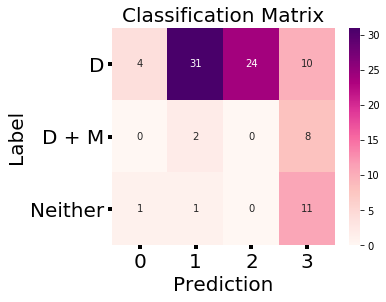

In [29]:
fig, ax = plt.subplots(figsize=(5,4))
df = pd.DataFrame.from_dict({
    'cat': cats,
    'pred': mod_out,
    'subject_id': sids,
})
agg = pd.DataFrame(df.groupby(['cat', 'pred']).subject_id.count()).reset_index()
piv = agg.pivot_table(
    index='cat',
    columns='pred',
    values='subject_id',
    fill_value=0
)
sns.heatmap(piv, annot=True, ax=ax, cmap='RdPu')
fmt.despine_thicken_axes(
    ax=ax,
    lw=0,
    fontsize=20,
)
ax.tick_params(length=4, width=4)
ax.set_ylabel('Label')
ax.set_xlabel('Prediction')
ax.set_title('Classification Matrix', fontsize=20)
agg

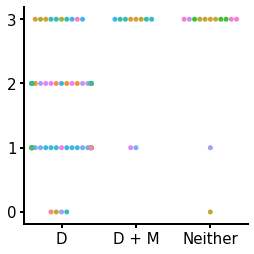

In [30]:
fig, ax = plt.subplots(figsize=(4,4))
sns.swarmplot(
    x=cats,
    y=mod_out,
    hue=sids,
    ax=ax,
)
ax.legend().remove()
ax.set_yticks(range(n_components))
fmt.despine_thicken_axes(
    ax=ax,
    lw=2,
    fontsize=15,
)
sns.despine()

In [31]:
import sklearn.metrics.cluster as clust
print('Classes:', n_components)
print('MI:',clust.mutual_info_score(cats, mod_out))
print('Normalized MI:',clust.normalized_mutual_info_score(cats, mod_out))
print('Adjusted MI:',clust.adjusted_mutual_info_score(cats, mod_out))

Classes: 4
MI: 0.23162269167861826
Normalized MI: 0.23466150926893206
Adjusted MI: 0.20553944060146837


## Adjusted Mutual Information Maximization

In [54]:
mg=np.meshgrid(mig_t,mdd_t)
print(len(mg))
for i, j in np.array(mg).reshape(-1,2):
    print(i,j)

2
0.0 0.02040816326530612
0.04081632653061224 0.061224489795918366
0.08163265306122448 0.1020408163265306
0.12244897959183673 0.14285714285714285
0.16326530612244897 0.18367346938775508
0.2040816326530612 0.22448979591836732
0.24489795918367346 0.26530612244897955
0.2857142857142857 0.3061224489795918
0.32653061224489793 0.3469387755102041
0.36734693877551017 0.3877551020408163
0.4081632653061224 0.42857142857142855
0.44897959183673464 0.4693877551020408
0.4897959183673469 0.5102040816326531
0.5306122448979591 0.5510204081632653
0.5714285714285714 0.5918367346938775
0.6122448979591836 0.6326530612244897
0.6530612244897959 0.673469387755102
0.6938775510204082 0.7142857142857142
0.7346938775510203 0.7551020408163265
0.7755102040816326 0.7959183673469387
0.8163265306122448 0.836734693877551
0.8571428571428571 0.8775510204081632
0.8979591836734693 0.9183673469387754
0.9387755102040816 0.9591836734693877
0.9795918367346939 1.0
0.0 0.02040816326530612
0.04081632653061224 0.061224489795918366

0.4081632653061224 0.42857142857142855
0.44897959183673464 0.4693877551020408
0.4897959183673469 0.5102040816326531
0.5306122448979591 0.5510204081632653
0.5714285714285714 0.5918367346938775
0.6122448979591836 0.6326530612244897
0.6530612244897959 0.673469387755102
0.6938775510204082 0.7142857142857142
0.7346938775510203 0.7551020408163265
0.7755102040816326 0.7959183673469387
0.8163265306122448 0.836734693877551
0.8571428571428571 0.8775510204081632
0.8979591836734693 0.9183673469387754
0.9387755102040816 0.9591836734693877
0.9795918367346939 1.0
0.0 0.02040816326530612
0.04081632653061224 0.061224489795918366
0.08163265306122448 0.1020408163265306
0.12244897959183673 0.14285714285714285
0.16326530612244897 0.18367346938775508
0.2040816326530612 0.22448979591836732
0.24489795918367346 0.26530612244897955
0.2857142857142857 0.3061224489795918
0.32653061224489793 0.3469387755102041
0.36734693877551017 0.3877551020408163
0.4081632653061224 0.42857142857142855
0.44897959183673464 0.46938

22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
22.02040816326531 22.02040816326531
23.714285714285715 23.714285714285715
23.714285714285715 23.714285714285715
23.714285714285715 23.714285714285715
23.714285714285715 23.714285714285715
23.714285714285715 23.714285714285715
23.714285714285715 23.714285714285715
23.714285714285715 23.714285714285715
23.714285714285715 23.714285714285715
23.714285714285715 23.714285714285715
23.714285714285715 23.714285714285715
23.714285714285715 23.714285714285715
23.714285714285715 23.714285714285715
23.7

72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
72.83673469387756 72.83673469387756
74.53061224489797 74.53061224489797
74.53061224489797 74.53061224489797
74.53061224489797 74.53061224489797
74.53061224489797 74.53061224489797
74.53061224489797 74.53061224489797
74.53061224489797 74.53061224489797
74.53061224489797 74.53061224489797
74.53061224489797 74.53061224489797
74.53061224489797 74.53061224489797
74.53061224489797 74.53061224489797
74.53061224489797 74.53061224489797
74.53061224489797 74.5306122

In [77]:
from tqdm.notebook import tqdm
mig_ts=[]
mdd_ts=[]
amis=[]
steps = 50

mig_t = np.linspace(0,1,steps)
mdd_t = np.linspace(0,83,steps)
mg = np.meshgrid(mig_t, mdd_t)
for mig_thresh, mdd_thresh in tqdm(np.array(mg).T.reshape(-1,2)):
    print(mig_thresh, mdd_thresh)
    mdd = np.array(end_sevs) > mdd_thresh
    mdd = mdd.astype(int)
    mig = np.array(end_mig_freqs) >= mig_thresh
    mig = mig.astype(int)
    cats = []
    for dep, m in zip(mdd,mig):
        if dep and m:
            cats.append('D + M')
        if dep and not m:
            cats.append('D')
        if not dep and m:
            cats.append('M')
        if not dep and not m:
            cats.append('Neither')
    cats = np.array(cats)
    ami = clust.adjusted_mutual_info_score(cats, mod_out)
    mig_ts.append(mig_thresh)
    mdd_ts.append(mdd_thresh)
    amis.append(ami)

0.0 0.0
0.0 1.6938775510204083
0.0 3.3877551020408165
0.0 5.081632653061225
0.0 6.775510204081633
0.0 8.46938775510204
0.0 10.16326530612245
0.0 11.857142857142858
0.0 13.551020408163266
0.0 15.244897959183675
0.0 16.93877551020408
0.0 18.63265306122449
0.0 20.3265306122449
0.0 22.02040816326531
0.0 23.714285714285715
0.0 25.408163265306126
0.0 27.102040816326532
0.0 28.79591836734694
0.0 30.48979591836735
0.0 32.183673469387756
0.0 33.87755102040816
0.0 35.57142857142858
0.0 37.26530612244898
0.0 38.95918367346939
0.0 40.6530612244898
0.0 42.3469387755102
0.0 44.04081632653062
0.0 45.734693877551024
0.0 47.42857142857143
0.0 49.12244897959184
0.0 50.81632653061225
0.0 52.51020408163266
0.0 54.204081632653065
0.0 55.89795918367347
0.0 57.59183673469388
0.0 59.28571428571429
0.0 60.9795918367347
0.0 62.673469387755105
0.0 64.36734693877551
0.0 66.06122448979592
0.0 67.75510204081633
0.0 69.44897959183673
0.0 71.14285714285715
0.0 72.83673469387756
0.0 74.53061224489797
0.0 76.2244897959

0.1020408163265306 38.95918367346939
0.1020408163265306 40.6530612244898
0.1020408163265306 42.3469387755102
0.1020408163265306 44.04081632653062
0.1020408163265306 45.734693877551024
0.1020408163265306 47.42857142857143
0.1020408163265306 49.12244897959184
0.1020408163265306 50.81632653061225
0.1020408163265306 52.51020408163266
0.1020408163265306 54.204081632653065
0.1020408163265306 55.89795918367347
0.1020408163265306 57.59183673469388
0.1020408163265306 59.28571428571429
0.1020408163265306 60.9795918367347
0.1020408163265306 62.673469387755105
0.1020408163265306 64.36734693877551
0.1020408163265306 66.06122448979592
0.1020408163265306 67.75510204081633
0.1020408163265306 69.44897959183673
0.1020408163265306 71.14285714285715
0.1020408163265306 72.83673469387756
0.1020408163265306 74.53061224489797
0.1020408163265306 76.22448979591837
0.1020408163265306 77.91836734693878
0.1020408163265306 79.61224489795919
0.1020408163265306 81.3061224489796
0.1020408163265306 83.0
0.1224489795918

0.22448979591836732 6.775510204081633
0.22448979591836732 8.46938775510204
0.22448979591836732 10.16326530612245
0.22448979591836732 11.857142857142858
0.22448979591836732 13.551020408163266
0.22448979591836732 15.244897959183675
0.22448979591836732 16.93877551020408
0.22448979591836732 18.63265306122449
0.22448979591836732 20.3265306122449
0.22448979591836732 22.02040816326531
0.22448979591836732 23.714285714285715
0.22448979591836732 25.408163265306126
0.22448979591836732 27.102040816326532
0.22448979591836732 28.79591836734694
0.22448979591836732 30.48979591836735
0.22448979591836732 32.183673469387756
0.22448979591836732 33.87755102040816
0.22448979591836732 35.57142857142858
0.22448979591836732 37.26530612244898
0.22448979591836732 38.95918367346939
0.22448979591836732 40.6530612244898
0.22448979591836732 42.3469387755102
0.22448979591836732 44.04081632653062
0.22448979591836732 45.734693877551024
0.22448979591836732 47.42857142857143
0.22448979591836732 49.12244897959184
0.224489

0.3061224489795918 77.91836734693878
0.3061224489795918 79.61224489795919
0.3061224489795918 81.3061224489796
0.3061224489795918 83.0
0.32653061224489793 0.0
0.32653061224489793 1.6938775510204083
0.32653061224489793 3.3877551020408165
0.32653061224489793 5.081632653061225
0.32653061224489793 6.775510204081633
0.32653061224489793 8.46938775510204
0.32653061224489793 10.16326530612245
0.32653061224489793 11.857142857142858
0.32653061224489793 13.551020408163266
0.32653061224489793 15.244897959183675
0.32653061224489793 16.93877551020408
0.32653061224489793 18.63265306122449
0.32653061224489793 20.3265306122449
0.32653061224489793 22.02040816326531
0.32653061224489793 23.714285714285715
0.32653061224489793 25.408163265306126
0.32653061224489793 27.102040816326532
0.32653061224489793 28.79591836734694
0.32653061224489793 30.48979591836735
0.32653061224489793 32.183673469387756
0.32653061224489793 33.87755102040816
0.32653061224489793 35.57142857142858
0.32653061224489793 37.26530612244898

0.42857142857142855 8.46938775510204
0.42857142857142855 10.16326530612245
0.42857142857142855 11.857142857142858
0.42857142857142855 13.551020408163266
0.42857142857142855 15.244897959183675
0.42857142857142855 16.93877551020408
0.42857142857142855 18.63265306122449
0.42857142857142855 20.3265306122449
0.42857142857142855 22.02040816326531
0.42857142857142855 23.714285714285715
0.42857142857142855 25.408163265306126
0.42857142857142855 27.102040816326532
0.42857142857142855 28.79591836734694
0.42857142857142855 30.48979591836735
0.42857142857142855 32.183673469387756
0.42857142857142855 33.87755102040816
0.42857142857142855 35.57142857142858
0.42857142857142855 37.26530612244898
0.42857142857142855 38.95918367346939
0.42857142857142855 40.6530612244898
0.42857142857142855 42.3469387755102
0.42857142857142855 44.04081632653062
0.42857142857142855 45.734693877551024
0.42857142857142855 47.42857142857143
0.42857142857142855 49.12244897959184
0.42857142857142855 50.81632653061225
0.428571

0.5306122448979591 6.775510204081633
0.5306122448979591 8.46938775510204
0.5306122448979591 10.16326530612245
0.5306122448979591 11.857142857142858
0.5306122448979591 13.551020408163266
0.5306122448979591 15.244897959183675
0.5306122448979591 16.93877551020408
0.5306122448979591 18.63265306122449
0.5306122448979591 20.3265306122449
0.5306122448979591 22.02040816326531
0.5306122448979591 23.714285714285715
0.5306122448979591 25.408163265306126
0.5306122448979591 27.102040816326532
0.5306122448979591 28.79591836734694
0.5306122448979591 30.48979591836735
0.5306122448979591 32.183673469387756
0.5306122448979591 33.87755102040816
0.5306122448979591 35.57142857142858
0.5306122448979591 37.26530612244898
0.5306122448979591 38.95918367346939
0.5306122448979591 40.6530612244898
0.5306122448979591 42.3469387755102
0.5306122448979591 44.04081632653062
0.5306122448979591 45.734693877551024
0.5306122448979591 47.42857142857143
0.5306122448979591 49.12244897959184
0.5306122448979591 50.816326530612

0.6326530612244897 30.48979591836735
0.6326530612244897 32.183673469387756
0.6326530612244897 33.87755102040816
0.6326530612244897 35.57142857142858
0.6326530612244897 37.26530612244898
0.6326530612244897 38.95918367346939
0.6326530612244897 40.6530612244898
0.6326530612244897 42.3469387755102
0.6326530612244897 44.04081632653062
0.6326530612244897 45.734693877551024
0.6326530612244897 47.42857142857143
0.6326530612244897 49.12244897959184
0.6326530612244897 50.81632653061225
0.6326530612244897 52.51020408163266
0.6326530612244897 54.204081632653065
0.6326530612244897 55.89795918367347
0.6326530612244897 57.59183673469388
0.6326530612244897 59.28571428571429
0.6326530612244897 60.9795918367347
0.6326530612244897 62.673469387755105
0.6326530612244897 64.36734693877551
0.6326530612244897 66.06122448979592
0.6326530612244897 67.75510204081633
0.6326530612244897 69.44897959183673
0.6326530612244897 71.14285714285715
0.6326530612244897 72.83673469387756
0.6326530612244897 74.53061224489797


0.7346938775510203 69.44897959183673
0.7346938775510203 71.14285714285715
0.7346938775510203 72.83673469387756
0.7346938775510203 74.53061224489797
0.7346938775510203 76.22448979591837
0.7346938775510203 77.91836734693878
0.7346938775510203 79.61224489795919
0.7346938775510203 81.3061224489796
0.7346938775510203 83.0
0.7551020408163265 0.0
0.7551020408163265 1.6938775510204083
0.7551020408163265 3.3877551020408165
0.7551020408163265 5.081632653061225
0.7551020408163265 6.775510204081633
0.7551020408163265 8.46938775510204
0.7551020408163265 10.16326530612245
0.7551020408163265 11.857142857142858
0.7551020408163265 13.551020408163266
0.7551020408163265 15.244897959183675
0.7551020408163265 16.93877551020408
0.7551020408163265 18.63265306122449
0.7551020408163265 20.3265306122449
0.7551020408163265 22.02040816326531
0.7551020408163265 23.714285714285715
0.7551020408163265 25.408163265306126
0.7551020408163265 27.102040816326532
0.7551020408163265 28.79591836734694
0.7551020408163265 30.4

0.836734693877551 27.102040816326532
0.836734693877551 28.79591836734694
0.836734693877551 30.48979591836735
0.836734693877551 32.183673469387756
0.836734693877551 33.87755102040816
0.836734693877551 35.57142857142858
0.836734693877551 37.26530612244898
0.836734693877551 38.95918367346939
0.836734693877551 40.6530612244898
0.836734693877551 42.3469387755102
0.836734693877551 44.04081632653062
0.836734693877551 45.734693877551024
0.836734693877551 47.42857142857143
0.836734693877551 49.12244897959184
0.836734693877551 50.81632653061225
0.836734693877551 52.51020408163266
0.836734693877551 54.204081632653065
0.836734693877551 55.89795918367347
0.836734693877551 57.59183673469388
0.836734693877551 59.28571428571429
0.836734693877551 60.9795918367347
0.836734693877551 62.673469387755105
0.836734693877551 64.36734693877551
0.836734693877551 66.06122448979592
0.836734693877551 67.75510204081633
0.836734693877551 69.44897959183673
0.836734693877551 71.14285714285715
0.836734693877551 72.83673

0.9183673469387754 72.83673469387756
0.9183673469387754 74.53061224489797
0.9183673469387754 76.22448979591837
0.9183673469387754 77.91836734693878
0.9183673469387754 79.61224489795919
0.9183673469387754 81.3061224489796
0.9183673469387754 83.0
0.9387755102040816 0.0
0.9387755102040816 1.6938775510204083
0.9387755102040816 3.3877551020408165
0.9387755102040816 5.081632653061225
0.9387755102040816 6.775510204081633
0.9387755102040816 8.46938775510204
0.9387755102040816 10.16326530612245
0.9387755102040816 11.857142857142858
0.9387755102040816 13.551020408163266
0.9387755102040816 15.244897959183675
0.9387755102040816 16.93877551020408
0.9387755102040816 18.63265306122449
0.9387755102040816 20.3265306122449
0.9387755102040816 22.02040816326531
0.9387755102040816 23.714285714285715
0.9387755102040816 25.408163265306126
0.9387755102040816 27.102040816326532
0.9387755102040816 28.79591836734694
0.9387755102040816 30.48979591836735
0.9387755102040816 32.183673469387756
0.9387755102040816 33.

,mig_thresh,mdd_thresh,ami
count,2500.000000,2500.000000,2500.000000
mean,0.500000,41.500000,0.057713
std,0.294566,24.449017,0.048602
min,0.000000,0.000000,-0.011568
25%,0.244898,20.326531,0.014882
50%,0.500000,41.500000,0.045624
75%,0.755102,62.673469,0.085622
max,1.000000,83.000000,0.212396


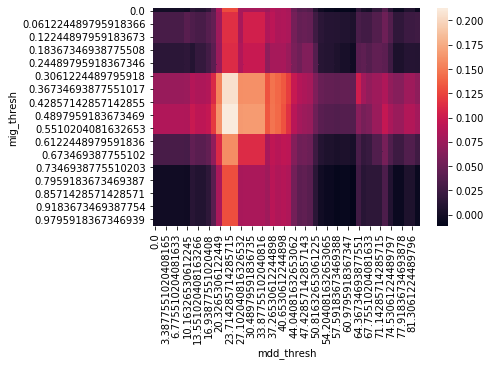

In [78]:
ami_df = pd.DataFrame.from_dict({'mig_thresh': mig_ts, 'mdd_thresh': mdd_ts, 'ami': amis})
piv = ami_df.pivot_table(
    index='mig_thresh',
    columns='mdd_thresh',
    values='ami'
)
sns.heatmap(piv)
ami_df.describe()

In [72]:
ami_df[ami_df.mig_thresh < .4].sort_values(by=['ami'], ascending=False).head(n=40)

,mig_thresh,mdd_thresh,ami
583,0.326531,0.346939,0.074063
233,0.326531,0.346939,0.074063
308,0.326531,0.346939,0.074063
733,0.326531,0.346939,0.074063
734,0.367347,0.387755,0.074063
758,0.326531,0.346939,0.074063
284,0.367347,0.387755,0.074063
283,0.326531,0.346939,0.074063
759,0.367347,0.387755,0.074063
783,0.326531,0.346939,0.074063


In [61]:
m = np.array([0.12897167, 0.12697423, 0.09193681, 0.12882064, 0.13359685,
       0.12315093, 0.12315093, 0.11567385, 0.1266268 , 0.08669202,
       0.12778371, 0.12882064, 0.13510643, 0.15375225, 0.13553153,
       0.12882064, 0.133603  , 0.12315093, 0.133603  , 0.133603  ,
       0.12783666, 0.11609185, 0.12778371, 0.13452016, 0.12353614,
       0.12693489, 0.12256932, 0.1232773 , 0.09265472, 0.06521178,
       0.12699836, 0.11725153, 0.12783666, 0.09064966, 0.12315093,
       0.12699836, 0.12778371, 0.12882064])
print('Mean:',m.mean())
print('Std:', m.std())
print('Min:', m.min())
print('Max:', m.max())

Mean: 0.12234937473684213
Std: 0.01614380498846437
Min: 0.06521178
Max: 0.15375225
